In [2]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['/home/tm/projects/Open_Close_GNN-1/'])

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] on linux


In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from seaborn import heatmap
from sklearn.model_selection import GroupKFold
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm

from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
from model.utils import device, eval_epoch, train, train_epoch, load_data_and_groups

import pickle

In [4]:
np.random.seed(42)

In [5]:
def load_data(band):
    if band == 'delta':
        opened = np.load(f'/home/tm/projects/Open_Close_GNN-1/data_eeg/Users/kireev-sci4/Downloads/all_con_matr/EO-01-{band}-2_cycles-pli-all_con_matrices.npy')
        closed = np.load(f'/home/tm/projects/Open_Close_GNN-1/data_eeg/Users/kireev-sci4/Downloads/all_con_matr/EC-02-{band}-2_cycles-pli-all_con_matrices.npy')
    else:
        opened = np.load(f'/home/tm/projects/Open_Close_GNN-1/data_eeg/Users/kireev-sci4/Downloads/all_con_matr/EO-01-{band}-7_cycles-pli-all_con_matrices.npy')
        closed = np.load(f'/home/tm/projects/Open_Close_GNN-1/data_eeg/Users/kireev-sci4/Downloads/all_con_matr/EC-02-{band}-7_cycles-pli-all_con_matrices.npy')
    return opened, closed

In [6]:
opened_alpha, closed_alpha = load_data('alpha')

In [7]:
opened_alpha.shape

(109, 64, 64)

In [8]:
full_dataset = OpenCloseDataset(datafolder='../data/', # dir where the processed files will be stored
                                open_file=opened_alpha, # data should be np.array of size (n_subjects, n_rois, n_rois)
                                close_file=closed_alpha, # an array for closed and opened eyes
                                reload=True, # whether you want to reload already processed graphs
                                k_degree=3) # k degree

Processing...
Done!


Since we have two scans for one person, to avoid data leak we define groups, where each subject represents one group. Then use these indeces to create train and validation sets.

In [9]:
labels = [full_dataset[i].y for i in range(len(full_dataset))]
groups = np.concatenate([
            np.arange(opened_alpha.shape[0], dtype=int), 
            np.arange(closed_alpha.shape[0], dtype=int)
            ])

In [10]:
gkf = GroupKFold()
for i, (train_index, val_test_index) in enumerate(gkf.split(labels, groups=groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, groups={groups[train_index]}")
    print(f"  Test:  index={val_test_index}, group={groups[val_test_index]}")
    break

Fold 0:
  Train: index=[  0   2   3   4   5   7   8   9  10  12  13  14  15  17  18  19  20  22
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  40  42  43
  44  45  47  48  49  50  52  53  54  55  57  58  59  60  62  63  64  65
  67  68  69  70  72  73  74  75  77  78  79  80  81  82  83  84  85  87
  88  89  90  92  93  94  95  97  98  99 100 102 103 104 105 109 111 112
 113 114 116 117 118 119 121 122 123 124 126 127 128 129 131 132 133 134
 135 136 137 138 139 141 142 143 144 146 147 148 149 151 152 153 154 156
 157 158 159 161 162 163 164 166 167 168 169 171 172 173 174 176 177 178
 179 181 182 183 184 186 187 188 189 190 191 192 193 194 196 197 198 199
 201 202 203 204 206 207 208 209 211 212 213 214], groups=[  0   2   3   4   5   7   8   9  10  12  13  14  15  17  18  19  20  22
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  40  42  43
  44  45  47  48  49  50  52  53  54  55  57  58  59  60  62  63  64  65
  67  68  69  70  72  73  74  75  77  78  7

In [11]:
train_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(train_index))
val_loader = DataLoader(full_dataset, batch_size=32, shuffle=False, sampler=SubsetRandomSampler(val_test_index))

## GCN

In [90]:
torch.cuda.empty_cache()

In [12]:
model = GCN(full_dataset.num_features, channels=[32, 16], dropout=0.2).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 150
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//5, gamma=0.1, last_epoch=-1)
sum(p.numel() for p in model.parameters())

2706

In [13]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=scheduler, save_best=True, path_to_save='whatever.pt')

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.7041, Test Loss 0.7253, Train Acc: 0.5067, Test Acc: 0.3958
Test precision: 0.3958, Test recall: 1.0000, Test F1: 0.5275
Epoch: 002, Train Loss: 0.6909, Test Loss 0.6865, Train Acc: 0.5372, Test Acc: 0.6146
Test precision: 0.5679, Test recall: 0.9688, Test F1: 0.7159
Epoch: 003, Train Loss: 0.6773, Test Loss 0.6815, Train Acc: 0.6176, Test Acc: 0.6094
Test precision: 0.5643, Test recall: 0.7118, Test F1: 0.6284
Epoch: 004, Train Loss: 0.6700, Test Loss 0.6567, Train Acc: 0.6265, Test Acc: 0.6458
Test precision: 0.6015, Test recall: 0.7529, Test F1: 0.6667
Epoch: 005, Train Loss: 0.6642, Test Loss 0.6524, Train Acc: 0.6168, Test Acc: 0.5885
Test precision: 0.6190, Test recall: 0.7054, Test F1: 0.6476
Epoch: 006, Train Loss: 0.6461, Test Loss 0.6447, Train Acc: 0.6488, Test Acc: 0.6198
Test precision: 0.5000, Test recall: 0.7544, Test F1: 0.5943
Epoch: 007, Train Loss: 0.6403, Test Loss 0.6040, Train Acc: 0.6451, Test Acc: 0.6562
Test precision: 0.6389, Test rec

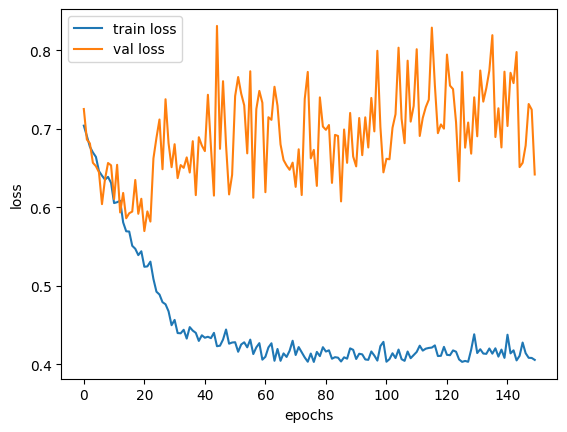

In [14]:
train_loss, val_loss, train_acc, test_acc = zip(*history)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

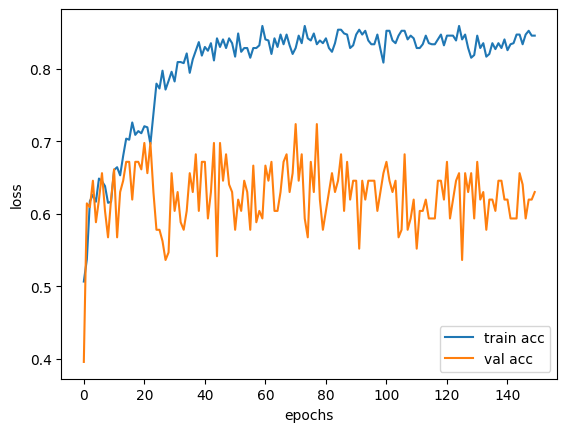

In [15]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='val acc')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [16]:
eval_epoch(val_loader, model, loss)

(0.660197526216507, 0.59375, 0.5888889, 0.72352946, 0.62946427)

# Group kFold

In [20]:
# GCN
channels = [32, 8]
n_epochs = 30
lr = 0.001
skf = GroupKFold(n_splits=10)
eval_metrics = np.zeros((skf.n_splits, 4))
crossval_dataset = full_dataset #+ val_dataset

labels = [crossval_dataset[i].y for i in range(len(crossval_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, groups=groups))):
    torch.cuda.empty_cache()
    model = GCN(crossval_dataset.num_features, channels=channels, dropout=0.3).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30//3, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(crossval_dataset[list(train_idx)], batch_size=16, shuffle=True)
    test_loader_ = DataLoader(crossval_dataset[list(test_idx)], batch_size=16, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(n_epochs):
        train_epoch(train_loader_, model, criterion, optimizer)
        train_loss, train_acc, _, _, train_f1 = eval_epoch(train_loader_, model, criterion)
        val_loss, test_acc, _, _, test_f1 = eval_epoch(test_loader_, model, criterion)
        scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f},',
              f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}')

        pr.append(test_f1)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
    eval_metrics[n_fold, 3] = np.mean(pr)

0it [00:00, ?it/s]

/home/tm/projects/Open_Close_GNN-1/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


0
Epoch: 000, Train Loss: 0.6927, Test Loss 0.6892, Train Acc: 0.5000, Test Acc: 0.5000, Test F1: 0.0000
Epoch: 001, Train Loss: 0.6800, Test Loss 0.6760, Train Acc: 0.5529, Test Acc: 0.5000, Test F1: 0.0000
Epoch: 002, Train Loss: 0.6524, Test Loss 0.6459, Train Acc: 0.7115, Test Acc: 0.6458, Test F1: 0.5357
Epoch: 003, Train Loss: 0.6187, Test Loss 0.6236, Train Acc: 0.6827, Test Acc: 0.5938, Test F1: 0.5529
Epoch: 004, Train Loss: 0.5742, Test Loss 0.5949, Train Acc: 0.7067, Test Acc: 0.5625, Test F1: 0.3500
Epoch: 005, Train Loss: 0.5520, Test Loss 0.6302, Train Acc: 0.7308, Test Acc: 0.5417, Test F1: 0.5556
Epoch: 006, Train Loss: 0.5298, Test Loss 0.5316, Train Acc: 0.7212, Test Acc: 0.7292, Test F1: 0.7786
Epoch: 007, Train Loss: 0.5246, Test Loss 0.5415, Train Acc: 0.7308, Test Acc: 0.6771, Test F1: 0.7434
Epoch: 008, Train Loss: 0.5211, Test Loss 0.5596, Train Acc: 0.7500, Test Acc: 0.6771, Test F1: 0.7143
Epoch: 009, Train Loss: 0.4866, Test Loss 0.5957, Train Acc: 0.7981, Te

In [21]:
print(np.mean(eval_metrics[:, 0])) # 0.7614)
print(np.std(eval_metrics[:, 0]))
print(np.mean(eval_metrics[:, 3]))


0.806249988079071
0.07713963100212202
0.7279629945755005


# Explanation

In [26]:
from collections import defaultdict
from model.explain import explain, aggregate_edge_directions, to_symmetrical, model_forward



In [29]:
close_salient = salient_edges(full_dataset, model, label=0)

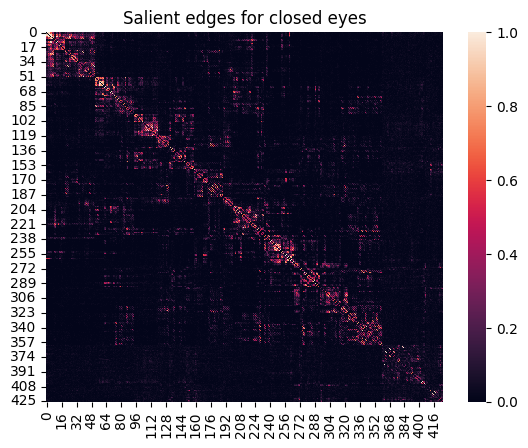

In [32]:
from seaborn import heatmap

heatmap(close_salient)
plt.title('Salient edges for closed eyes');